# This script demonstrates how to build a zero VAE with vae_tools

In [1]:
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
import vae_tools.loader
from vae_tools.zerovae import ZeroVae, ReconstructionLoss
vae_tools.sanity.check()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.datasets import mnist
import numpy as np
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
# resize the notebook if desired
#vae_tools.nb_tools.notebook_resize()
import matplotlib
import matplotlib.pyplot as plt

python version:  3.5.2
keras version: 2.2.4-tf
tensorflow version: 2.0.2
matplotlib uses:  module://ipykernel.pylab.backend_inline
No GPUs available


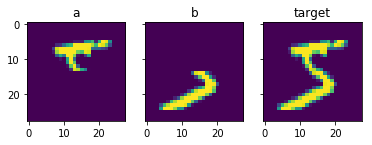

In [8]:
# Get the MNIST digits
x_train_target, y_train_target, x_test_target, y_test_target = vae_tools.loader.mnist(new_shape = (28*28,), kind='digit', get_single_label = None)
(x_train_a, x_train_b), (x_test_a, x_test_b), y_train, y_test = vae_tools.loader.mnist_split(flatten = True, split = 'hor', to_zero=True)

img_rows, img_cols, idx = 28, 28, 0
_, axs = plt.subplots(1,3, sharey=True)
axs[0].imshow(x_train_a[idx,:].reshape((img_rows, img_cols)))
axs[1].imshow(x_train_b[idx,:].reshape((img_rows, img_cols)))
axs[2].imshow(x_train_target[idx,:].reshape((img_rows, img_cols)))
axs[0].set_title("a")
axs[1].set_title("b")
axs[2].set_title("target")
plt.show()

# Concat the data sets

x_train = np.concatenate((x_train_a, x_train_b),axis=0)
x_test = np.concatenate((x_test_a, x_test_b),axis=0)
y_train = np.concatenate((y_train, y_train),axis=0)
y_test = np.concatenate((y_test, y_test),axis=0)

x_train_target = np.concatenate((x_train_target, x_train_target),axis=0)
x_test_target = np.concatenate((x_test_target, x_test_target),axis=0)


Store model to filename: tmp/myVAE.png and tmp/myVAE.svg
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
enc_0 (Dense)                   (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
enc_1 (Dense)                   (None, 128)          32896       enc_0[0][0]                      
__________________________________________________________________________________________________
mean_0 (Dense)                  (None, 2)            258         enc_1[0][0]                      
___________________________________

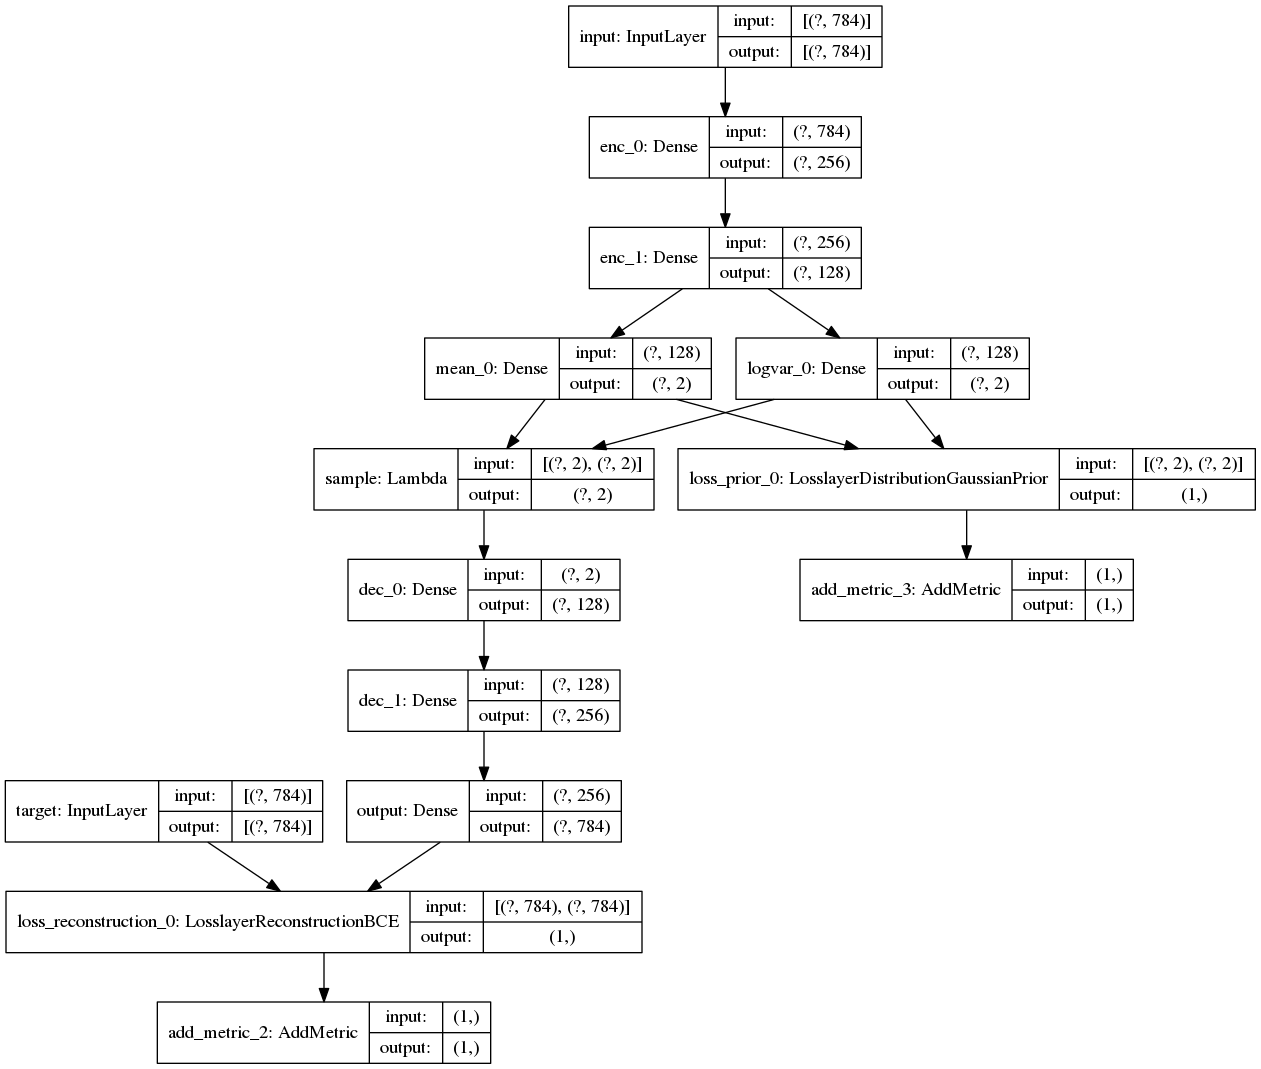

In [9]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
batch_size = 1024
original_dim = img_rows * img_cols * img_chns
intermediate_dim = 256
epochs = 10 # 50
z_dim = 2
beta = 1.

x_target = Input(shape=(original_dim,), name="target")

encoder = [[
    Input(shape=(original_dim,), name="input"),                       # Input layer
    Dense(intermediate_dim, activation='relu', name="enc_0"),         # First encoder layer
    Dense(int(intermediate_dim/2), activation='relu', name="enc_1")   # Second encoder layer
]]

decoder = [[
    Dense(int(intermediate_dim/2), activation='relu', name="dec_0"),  # First decoder layer
    Dense(intermediate_dim, activation='relu', name="dec_1"),         # Second decoder layer
    Dense(original_dim, activation='sigmoid', name="output")          # Output layer
]]

vae_obj = ZeroVae(z_dim, x_target, encoder, decoder, [original_dim], beta, reconstruction_loss_metrics = [ReconstructionLoss.BCE], name='ZeroVae')

vae = vae_obj.get_model(extra_inputs = [x_target])
vae.compile(optimizer='rmsprop', loss=None)
vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)

In [10]:
# Train
h = vae.fit([x_train, x_train_target],
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test, x_test_target], None),
            verbose = 1)

Train on 120000 samples, validate on 20000 samples
Epoch 1/10
120000/120000 [==============================] - 9s 78us/sample - loss: 223.6279 - loss_reconstruction_0_1: 218.0906 - loss_prior_0_1: 5.3098 - val_loss: 197.1418 - val_loss_reconstruction_0_1: 195.0359 - val_loss_prior_0_1: 2.0975

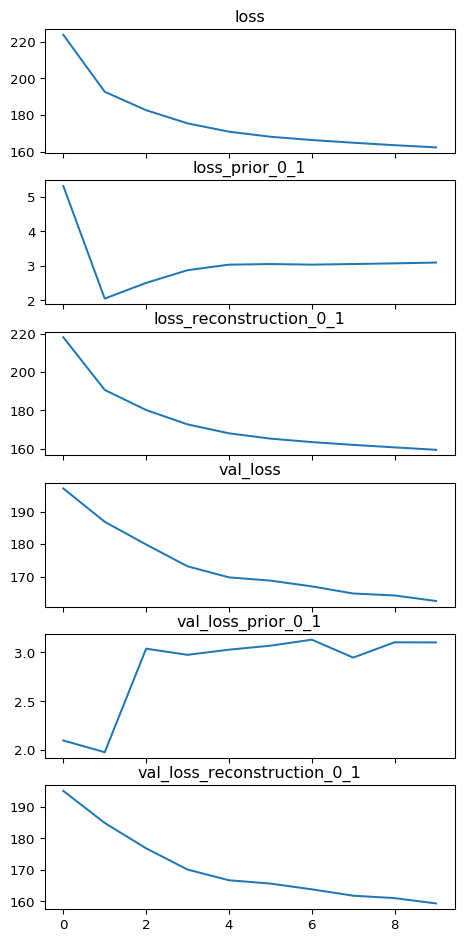

In [11]:
# Show the losses (loss is ELBO)
vae_tools.viz.plot_losses(h, dpi=96, figsize_height_factor = .325)
plt.show()

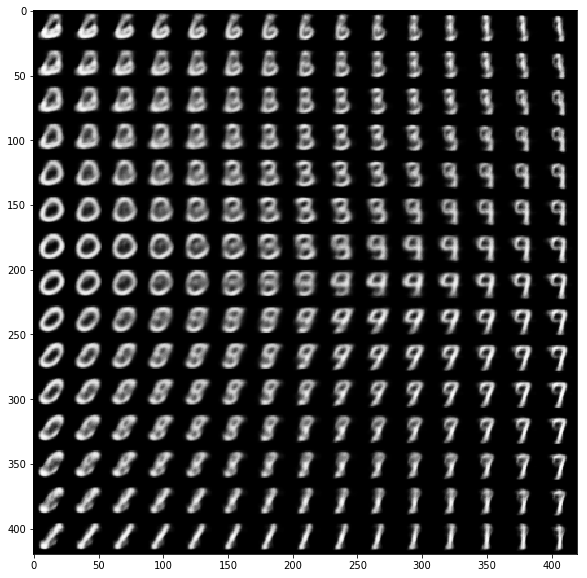

In [12]:
# build a digit generator that can sample from the learned distribution
generator = vae_obj.get_decoder()
from scipy.stats import norm
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-1-i) * digit_size: ((n-1-i) + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

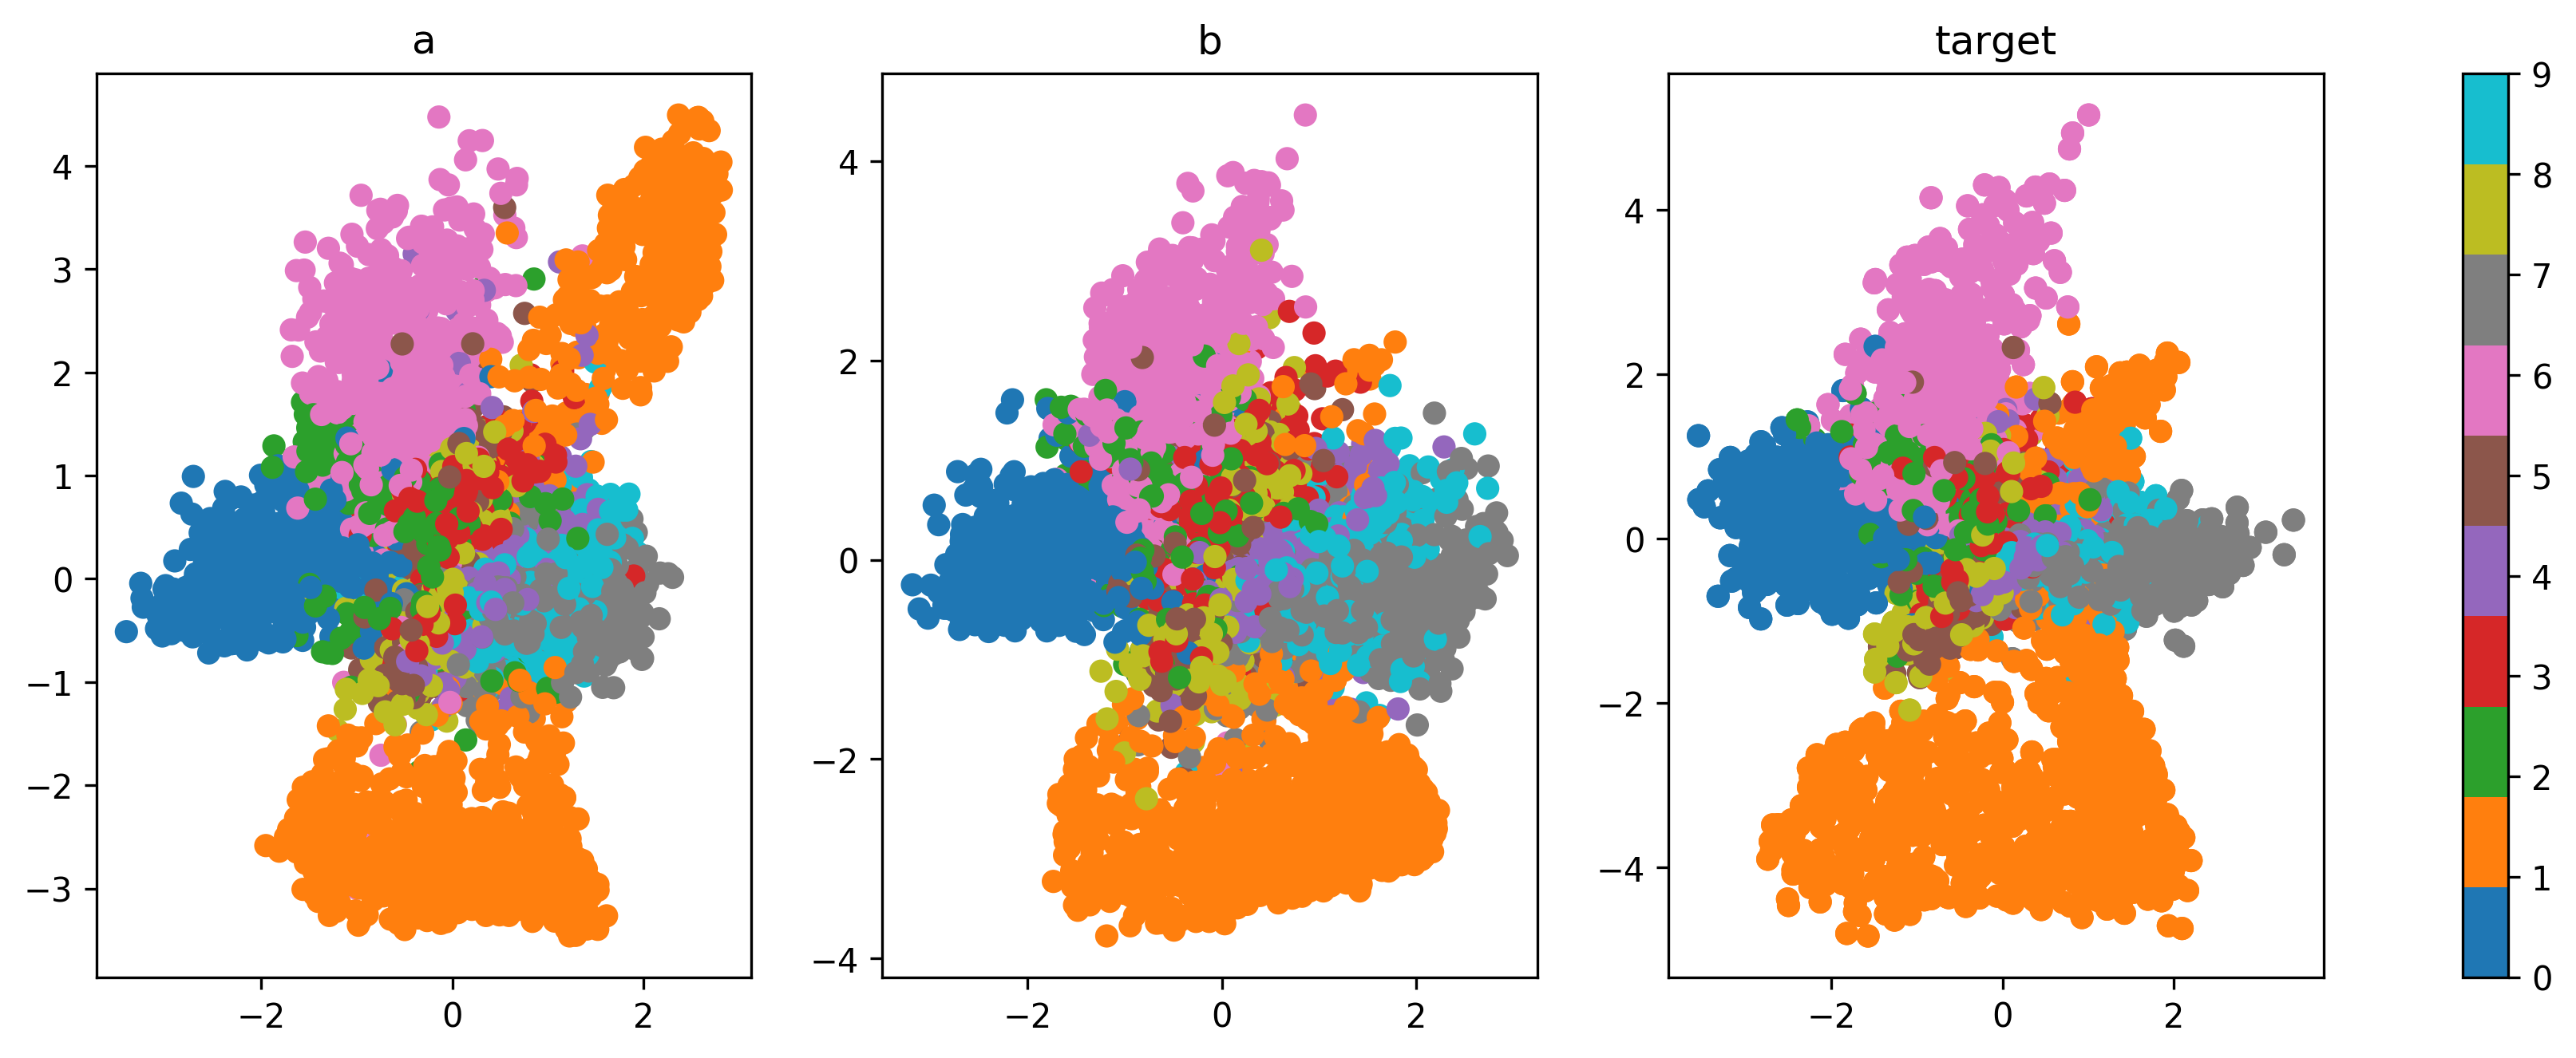

In [18]:
# build a model to project inputs on the latent space
encoder_input = [encoder[0][0]]
encoder_model = vae_obj.get_encoder_mean(encoder_input)
# display a 2D plot of the digit classes in the latent space
f, ax = plt.subplots(1,3, figsize=(15, 5), dpi=300)
# a
x_test_encoded = encoder_model.predict(x_test_a, batch_size=batch_size)
ax[0].scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test_target, cmap='tab10')
ax[0].set_title("a")
# b
x_test_encoded = encoder_model.predict(x_test_b, batch_size=batch_size)
ax[1].scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test_target, cmap='tab10')
ax[1].set_title("b")
# target (was not trained)
x_test_encoded = encoder_model.predict(x_test_target, batch_size=batch_size)
s = ax[2].scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
ax[2].set_title("target")

plt.colorbar(s, ax=ax)
#plt.axis("equal")
plt.show()